In [25]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pytesseract

In [37]:
file_name = 'temp/date_erg01.jpg'
image = cv2.imread(file_name)
psm = '--psm 13'

In [38]:
def noise_removal(image):
    kernel = np.ones((2, 2), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    kernel = np.ones((2, 2), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 5)
    return (image)

In [39]:
def pre_process(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    no_noise = noise_removal(thresh)
    no_noise_color = cv2.cvtColor(no_noise, cv2.COLOR_GRAY2RGB)
    return no_noise_color

In [40]:
def extract(pp_image):
    gray = cv2.cvtColor(pp_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (1,1), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = np.ones((1,1),np.float32)/25
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, blur, iterations=1)
    data = pytesseract.image_to_string(opening, lang='eng', config=psm)
    return data, opening


Apr 192021



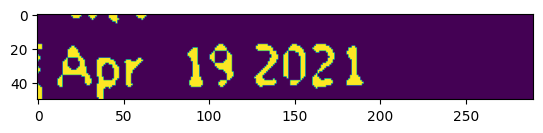

In [41]:
pre_processed_image = pre_process(image)
data, pic = extract(pre_processed_image)
print(data)
plt.imshow(pic)
